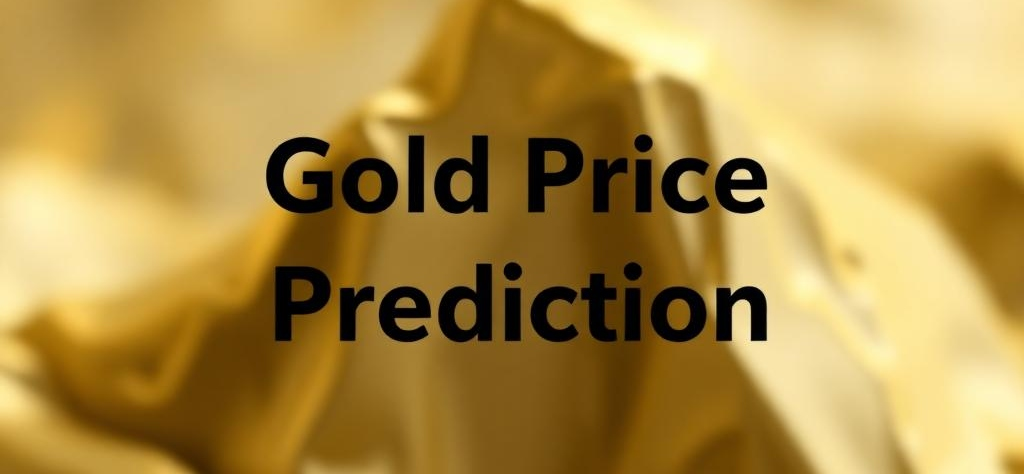

__In this notebook, we are going to build a time series model to predict the future price of gold, which can be very useful for traders. For this purpose, we use the historical gold price data for 10 years (from 2014 to 2024).__

### Let's get started:

# Step 1: Importing Libraries

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, root_mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
import joblib
import warnings
warnings.filterwarnings('ignore')

# Step 2: Reading Dataset

In [ ]:
df = pd.read_csv('data/Gold_Data_Updated.csv')

# Step 3: Dataset Overview

In [64]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,06-12-2024,79365.0,79328.0,79658.0,78741.0,NaN,0.36%
1,05-12-2024,79111.0,79882.0,80055.0,79049.0,156.12K,-1.04%
2,04-12-2024,79950.0,79640.0,80124.0,79293.0,171.79K,0.31%
3,03-12-2024,79686.0,79510.0,80000.0,79349.0,140.97K,0.35%
4,02-12-2024,79466.0,79923.0,80064.0,79047.0,163.54K,-0.84%
...,...,...,...,...,...,...,...
2610,05-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2611,04-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2612,03-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2613,02-12-2014,NaN,NaN,NaN,NaN,NaN,NaN


__As you can see, the data set includes daily gold price information including daily Open, High and Low prices and the final price of each day (Price) along with the volume of transactions and price changes in each day.__

__Dataset Basic Information:__

In [65]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2610,05-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2611,04-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2612,03-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2613,02-12-2014,NaN,NaN,NaN,NaN,NaN,NaN
2614,01-12-2014,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2615 entries, 0 to 2614
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2615 non-null   object 
 1   Price     2570 non-null   float64
 2   Open      2570 non-null   float64
 3   High      2570 non-null   float64
 4   Low       2570 non-null   float64
 5   Vol.      2567 non-null   object 
 6   Change %  2570 non-null   object 
dtypes: float64(4), object(3)
memory usage: 143.1+ KB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [67]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [68]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [69]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [70]:
df.head()

,Date,Price,Open,High,Low
0,2014-12-01,NaN,NaN,NaN,NaN
1,2014-12-02,NaN,NaN,NaN,NaN
2,2014-12-03,NaN,NaN,NaN,NaN
3,2014-12-04,NaN,NaN,NaN,NaN
4,2014-12-05,NaN,NaN,NaN,NaN


## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [71]:
df.duplicated().sum()

0

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [72]:
df.isnull().sum()

Date      0
Price    45
Open     45
High     45
Low      45
dtype: int64

In [73]:
df = df.dropna(axis=0)
df.head()

,Date,Price,Open,High,Low
45,2015-02-02,26519.0,25241.0,26582.0,24856.0
46,2015-02-03,26060.0,26347.0,26347.0,25886.0
47,2015-02-04,26367.0,26125.0,26504.0,26035.0
48,2015-02-05,26288.0,26323.0,26415.0,26145.0
49,2015-02-06,26021.0,26360.0,26417.0,25934.0


# Step 5: Visualizing Gold Price History Data

__Interactive Gold Price Chart:__

In [74]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

In [75]:
test_size = df[df.Date.dt.year==2023].shape[0]
test_size

260

__Gold Price Training and Test Sets Plot:__

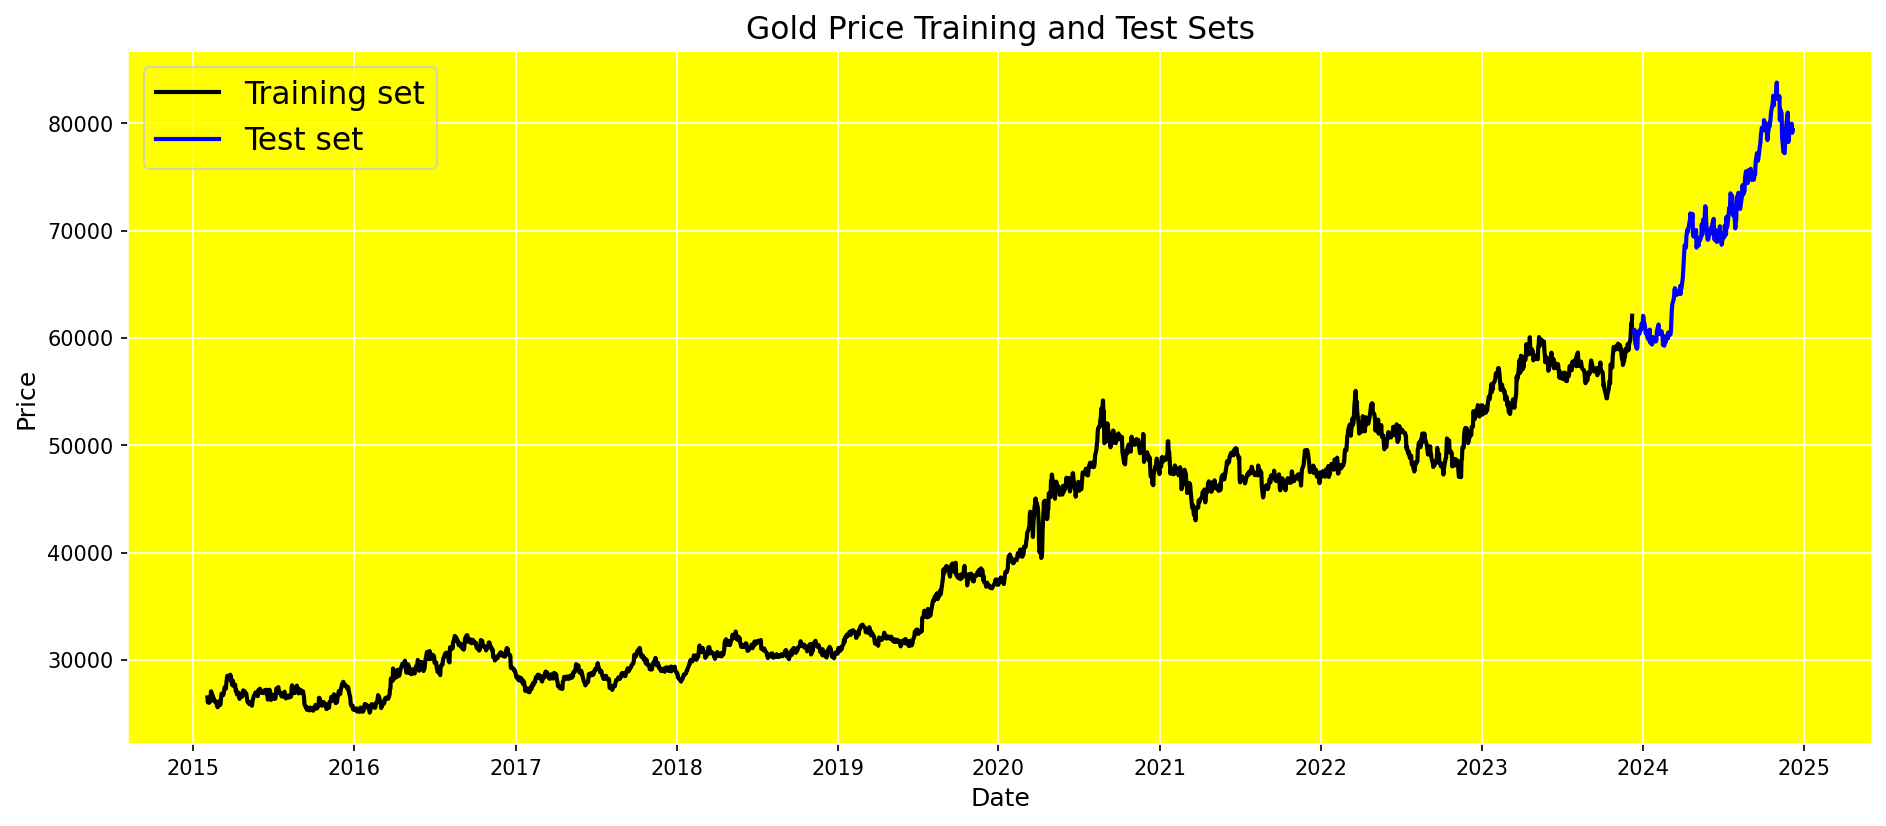

In [76]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 7: Data Scaling
__Since we aim to predict Price only based on its historical data, we scale Price using MinMaxScaler to avoid intensive computations:__

In [77]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

# Step 8: Restructure Data & Create Sliding Window
__The use of prior time steps to predict the next time step is called sliding window. In this way, time series data can be expressed as supervised learning. We can do this by using previous time steps as input variables and use the next time step as the output variable. The number of previous time steps is called the window width. Here we set window width to 60. Therefore, X_train and X_test will be nested lists containing lists of 60 time-stamp prices. y_train and y_test are also lists of gold prices containing the next day's gold price corresponds to each list in X_train and X_test respectively:__

In [78]:
window_size = 60

__Training Set:__

In [79]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [80]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

__Test Set:__

In [81]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [82]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Step 9: Converting Data to Numpy Arrays

__Now X_train and X_test are nested lists (two-dimensional lists) and y_train is a one-dimensional list. We need to convert them to numpy arrays with a higher dimension, which is the data format accepted by TensorFlow when training the neural network:__

In [83]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [84]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [85]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2250, 60, 1)
y_train Shape:  (2250, 1)
X_test Shape:   (260, 60, 1)
y_test Shape:   (260, 1)


# Step 10: Creating an LSTM Network 
__We build an LSTM network, which is a type of Recurrent Neural Networks designed to solve vanishing gradient problem:__

__Model Definition:__

In [86]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)  # Use ReLU or remove this layer
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

__Model Training:__

In [87]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0129 - val_loss: 0.0020
Epoch 2/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 8.9617e-04 - val_loss: 0.0013
Epoch 3/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7.1937e-04 - val_loss: 7.4004e-04
Epoch 4/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 6.3770e-04 - val_loss: 0.0018
Epoch 5/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 6.7582e-04 - val_loss: 7.0253e-04
Epoch 6/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6.3581e-04 - val_loss: 9.4210e-04
Epoch 7/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 4.8538e-04 - val_loss: 9.6413e-04
Epoch 8/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 5.3507e-04 - val_loss: 7.0254e-04
Epoch 9/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 4.1676e-04 - val_loss: 4.1091e-04
Epoch 10/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 4.3416e-04 - val_loss: 5.0737e-04
Epoch 11/150
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 4.0595e-04 - v

# Step 11: Model Evaluation
__Next, we evaluate our time series forecast using MAPE (Mean Absolute Percentage Error) metric:__

In [88]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.0528e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [89]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
RMSE = root_mean_squared_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [90]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test MAE:", MAE)
print("Test RMSE:", RMSE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.00045128128840588033
Test MAPE: 0.022747124085954584
Test MAE: 0.017048626193366688
Test RMSE: 0.021243384402078694
Test Accuracy: 0.9772528759140454


# Step 12: Visualizing Results

__Returning the actual and predicted Price values to their primary scale:__

In [91]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

__Investigating the closeness of the prices predicted by the model to the actual prices:__

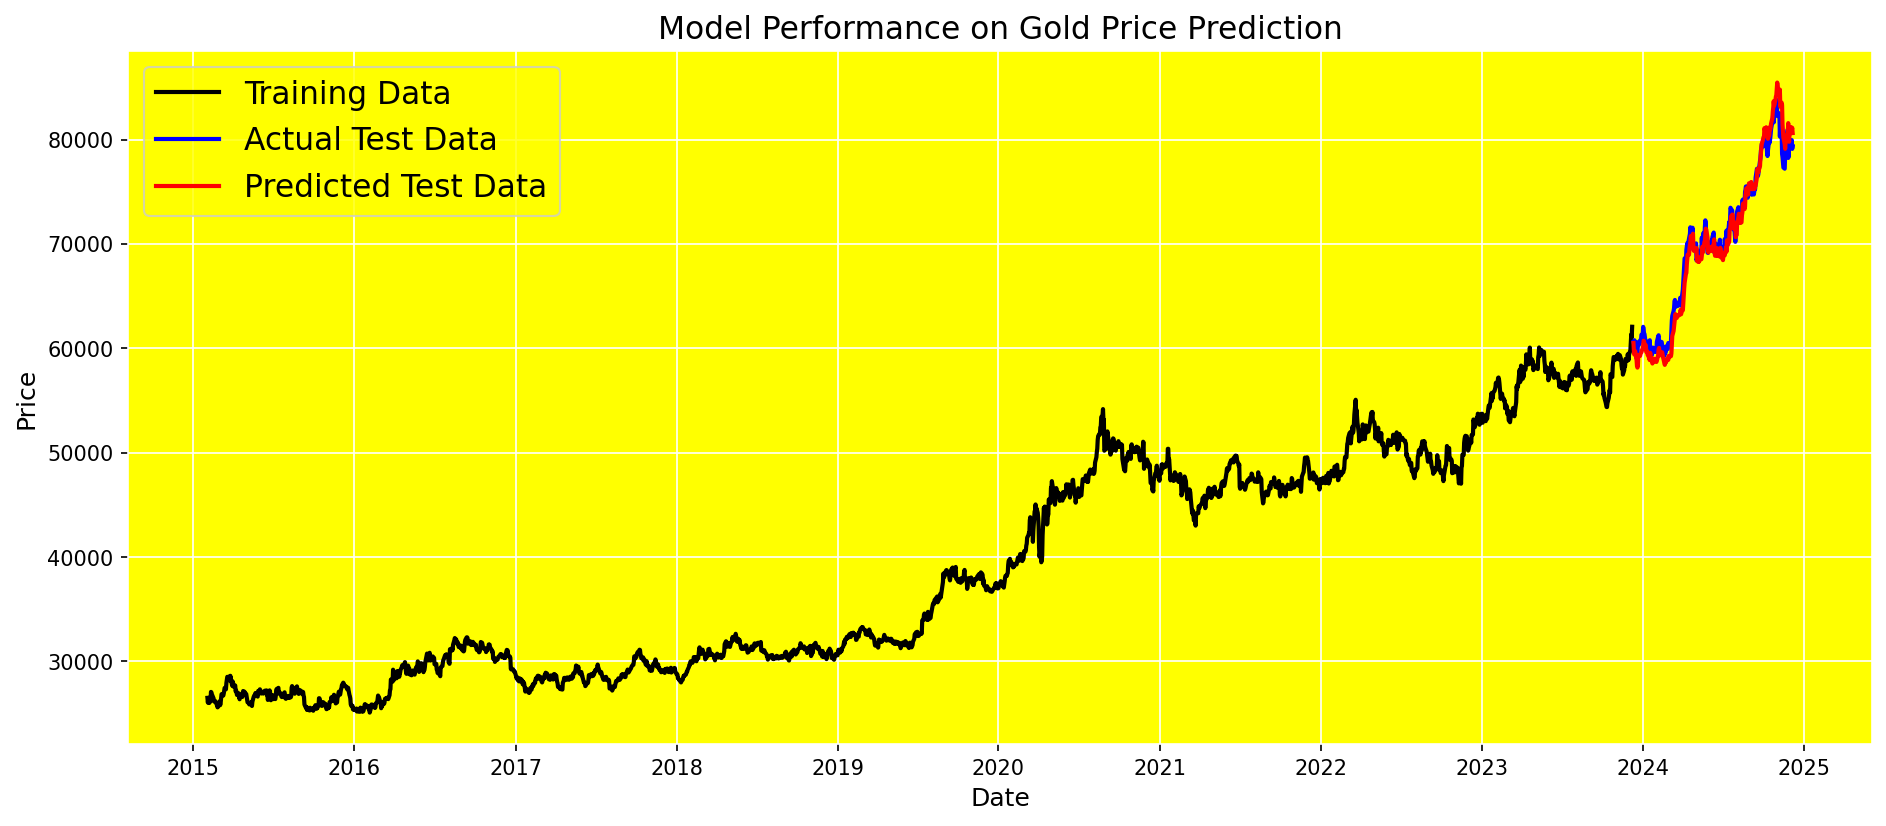

In [92]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Step 13: Saving Model 

__Saving the model for future use:__

In [93]:
model.save('model.h5')  # Save in HDF5 format

# Step 14: Predicting Future Prices 

__Predicting prices for upcoming days:__

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Future Predicted Prices:
{datetime.date(2024, 12, 7): 80749.69, datetime.date(2024, 12, 8): 81798.37, datetime.date(2024, 12, 9): 82716.89, datetime.date(2024, 12, 10): 83505.24, datetime.date(2024, 12, 11): 84281.74, datetime.date(2024, 12, 12): 85171.21, datetime.date(2024, 12, 13): 86209.54}


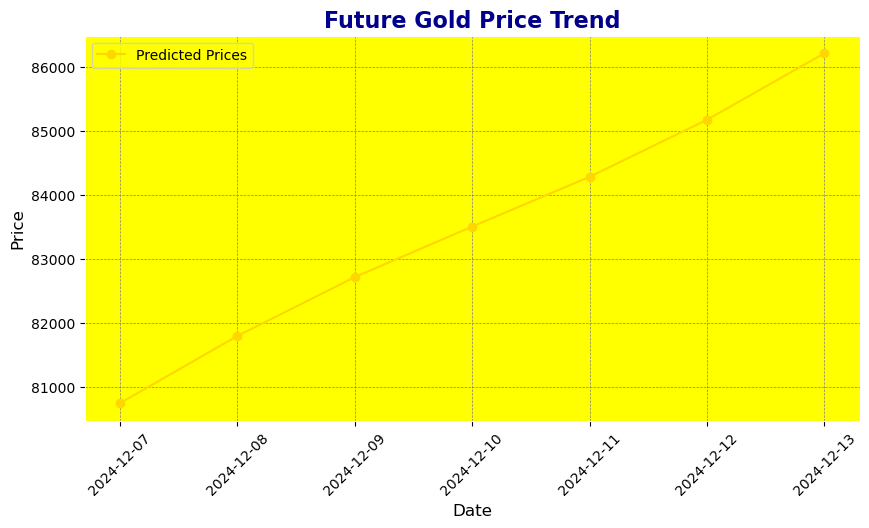

In [94]:
from datetime import timedelta

def predict_future_trend(model, recent_data, num_steps, scaler, features):
    """
    Predict future prices using the trained model and historical data.

    Parameters:
        model: Trained LSTM model.
        recent_data: DataFrame containing the most recent window_size rows of features.
        num_steps: Number of future time steps to predict.
        scaler: MinMaxScaler used for scaling the data.
        features: List of feature column names used in the model.

    Returns:
        future_predictions: List of predicted prices for the future.
    """
    # Ensure recent_data has the correct length
    if len(recent_data) != window_size:
        raise ValueError(f"recent_data must have exactly {window_size} rows.")

    # Scale the recent data
    scaled_recent_data = scaler.transform(recent_data[features])

    # Initialize input sequence
    input_sequence = scaled_recent_data[-window_size:]  # Take the last window_size rows
    input_sequence = input_sequence.reshape(1, window_size, len(features))

    # Predict future prices
    future_predictions = []
    for _ in range(num_steps):
        # Predict the next price
        next_prediction = model.predict(input_sequence)[0, 0]  # Get the single prediction value

        # Append the prediction to the results (inverse transform to get actual price)
        future_predictions.append(scaler.inverse_transform([[next_prediction]])[0, 0])

        # Update the input sequence: remove the oldest row, add the new prediction
        next_row = input_sequence[0, 1:, :]  # Remove the first row
        next_prediction_row = np.zeros((1, len(features)))  # Create a row for the next prediction
        next_prediction_row[0, 0] = next_prediction  # Set the predicted price
        input_sequence = np.vstack([next_row, next_prediction_row]).reshape(1, window_size, len(features))

    return future_predictions


# Predict the next 7 days
num_steps = 7
recent_data = df[-window_size:]  # Replace df with your actual DataFrame
features = ['Price']  # List of features used in the model
future_prices = predict_future_trend(model, recent_data, num_steps, scaler, features)

# Generate corresponding dates for the predictions
last_date = df['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, num_steps + 1)]

# Store results in a dictionary
future_predictions_dict = {date.date(): round(price, 2) for date, price in zip(future_dates, future_prices)}

# Display the dictionary
print("Future Predicted Prices:")
print(future_predictions_dict)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_prices, marker='o', label="Predicted Prices", color='gold')
plt.title("Future Gold Price Trend", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show() 

In [95]:
import plotly.graph_objects as go

# Plot Historical Data
fig = go.Figure()

# Add historical gold price data
fig.add_trace(
    go.Scatter(
        x=df['Date'],
        y=df['Price'],
        mode='lines',
        name='Historical Prices',
        line=dict(color='black', width=2),
    )
)

# Add future predicted prices
future_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=len(future_prices), freq='D')
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=future_prices,
        mode='lines+markers',
        name='Future Predictions',
        line=dict(color='red', dash='dot', width=3),
        marker=dict(color='red', size=6),
    )
)

# Update layout with good use of colors
fig.update_layout(
    title={
        'text': "Gold Price History and Future Predictions",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title="Date",
    yaxis_title="Price",
    plot_bgcolor='rgba(240,240,240,1)',  # Light grey background
    paper_bgcolor='rgba(255, 223, 0, 0.8)',  # Yellow paper background
    legend=dict(
        bgcolor='rgba(255,255,255,0.6)',
        bordercolor='black',
        borderwidth=1,
        font=dict(size=12)
    ),
    xaxis=dict(gridcolor='lightgrey'),
    yaxis=dict(gridcolor='lightgrey')
)

# Show the combined plot
fig.show()
